# Fuzzy Rough Set Based Feature Evaluation

This notebook implements the fuzzy rough set methods for feature evaluation in Python.
Based on the MATLAB code for computing generalized classification certainty and dependency.

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris, load_wine
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

## Implementation of Fuzzy Rough Set Functions

In [3]:
def certainty_theta_gs(data_array, delta, k):
    """
    Compute the generalized classification certainty with fuzzy rough sets
    
    Parameters:
    -----------
    data_array : numpy array
        Dataset with features in columns and class labels in last column
    delta : float
        Bandwidth parameter (controls fuzziness)
    k : int
        Number of nearest neighbors to consider
    
    Returns:
    --------
    r : float
        Average certainty measure
    """
    m, n = data_array.shape
    
    # Extract labels
    labels = data_array[:, -1]
    unique_labels = np.unique(labels)
    
    CC = np.zeros(m)
    
    for i in range(m):
        # Find samples with different labels
        label_diff = np.where(labels != labels[i])[0]
        
        if len(label_diff) == 0:
            continue
            
        # Calculate distances to samples with different labels
        temp_dist = np.sum((data_array[label_diff, :-1] - data_array[i, :-1])**2, axis=1)
        
        # Sort and get k nearest
        temp_sorted = np.sort(temp_dist)
        M = temp_sorted[:k] if len(temp_sorted) >= k else temp_sorted
        
        # Calculate LA (lower approximation)
        LA = np.sum(np.sqrt(1 - (np.exp(-M/delta))**2))
        
        # Calculate UA (upper approximation)
        UA = 0
        for class_label in unique_labels:
            if labels[i] != class_label:
                label_class = np.where(labels == class_label)[0]
                
                if len(label_class) == 0:
                    continue
                    
                temp_dist = np.sum((data_array[label_class, :-1] - data_array[i, :-1])**2, axis=1)
                temp_sorted = np.sort(temp_dist)
                M = temp_sorted[:k] if len(temp_sorted) >= k else temp_sorted
                
                UP = np.sum(1 - np.sqrt(1 - (np.exp(-M/delta))**2))
                UA += UP
        
        CC[i] = (LA - UA) / k if k > 0 else 0
    
    return np.mean(CC)

In [4]:
def dependency_s_gs(data_array, delta, k):
    """
    Compute the generalized dependency with fuzzy rough sets
    
    Parameters:
    -----------
    data_array : numpy array
        Dataset with features in columns and class labels in last column
    delta : float
        Bandwidth parameter
    k : int
        Number of nearest neighbors (if k=1, uses single nearest neighbor)
    
    Returns:
    --------
    r : float
        Average dependency measure
    """
    m, n = data_array.shape
    r = 0
    
    for i in range(m):
        # Find samples with different labels
        label_diff = np.where(data_array[:, -1] != data_array[i, -1])[0]
        
        if len(label_diff) == 0:
            continue
            
        array_diff = data_array[label_diff, :-1]
        
        if k == 1:
            # Single nearest neighbor
            temp = np.minimum(np.abs(array_diff - data_array[i, :-1]), 1)
            distances = np.sum(temp**2, axis=1)
            value_nearest = np.min(distances)
            r += (1 - np.exp(-value_nearest / (2 * delta**2))) / m
        else:
            # k nearest neighbors using median
            temp = np.minimum(np.abs(array_diff - data_array[i, :-1]), 1)
            d = temp**2
            distances = np.sum(d, axis=1)
            sorted_indices = np.argsort(distances)
            
            k_actual = min(k, len(sorted_indices))
            median_point = np.median(array_diff[sorted_indices[:k_actual]], axis=0)
            value_nearest = np.sum((data_array[i, :-1] - median_point)**2)
            r += (1 - np.exp(-value_nearest / (2 * delta))) / m
    
    return r

## Test with Iris Dataset

In [5]:
# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Combine features and labels
data_array = np.column_stack([X_scaled, y])

print("Dataset shape:", data_array.shape)
print("Number of samples:", len(y))
print("Number of features:", X.shape[1])
print("Classes:", np.unique(y))

Dataset shape: (150, 5)
Number of samples: 150
Number of features: 4
Classes: [0 1 2]


## Compute Measures with Different Parameters

In [6]:
# Test with different parameter values
delta_values = [0.5, 1.0, 2.0, 5.0]
k_values = [1, 3, 5, 7]

print("="*70)
print("TESTING CERTAINTY MEASURE (certainty_theta_gs)")
print("="*70)

certainty_results = {}
for delta in delta_values:
    for k in k_values:
        cert = certainty_theta_gs(data_array, delta, k)
        certainty_results[(delta, k)] = cert
        print(f"delta={delta:4.1f}, k={k}: Certainty = {cert:.6f}")

print("\n" + "="*70)
print("TESTING DEPENDENCY MEASURE (dependency_s_gs)")
print("="*70)

dependency_results = {}
for delta in delta_values:
    for k in k_values:
        dep = dependency_s_gs(data_array, delta, k)
        dependency_results[(delta, k)] = dep
        print(f"delta={delta:4.1f}, k={k}: Dependency = {dep:.6f}")

TESTING CERTAINTY MEASURE (certainty_theta_gs)
delta= 0.5, k=1: Certainty = 0.884180
delta= 0.5, k=3: Certainty = 0.924140
delta= 0.5, k=5: Certainty = 0.941670
delta= 0.5, k=7: Certainty = 0.953065
delta= 1.0, k=1: Certainty = 0.748668
delta= 1.0, k=3: Certainty = 0.811061
delta= 1.0, k=5: Certainty = 0.842282
delta= 1.0, k=7: Certainty = 0.864239
delta= 2.0, k=1: Certainty = 0.563599
delta= 2.0, k=3: Certainty = 0.637930
delta= 2.0, k=5: Certainty = 0.678879
delta= 2.0, k=7: Certainty = 0.708895
delta= 5.0, k=1: Certainty = 0.248195
delta= 5.0, k=3: Certainty = 0.324388
delta= 5.0, k=5: Certainty = 0.371009
delta= 5.0, k=7: Certainty = 0.405820

TESTING DEPENDENCY MEASURE (dependency_s_gs)
delta= 0.5, k=1: Dependency = 0.785211
delta= 0.5, k=3: Dependency = 0.687632
delta= 0.5, k=5: Dependency = 0.712093
delta= 0.5, k=7: Dependency = 0.730455
delta= 1.0, k=1: Dependency = 0.448105
delta= 1.0, k=3: Dependency = 0.558931
delta= 1.0, k=5: Dependency = 0.582352
delta= 1.0, k=7: Dependenc

## Visualize Results

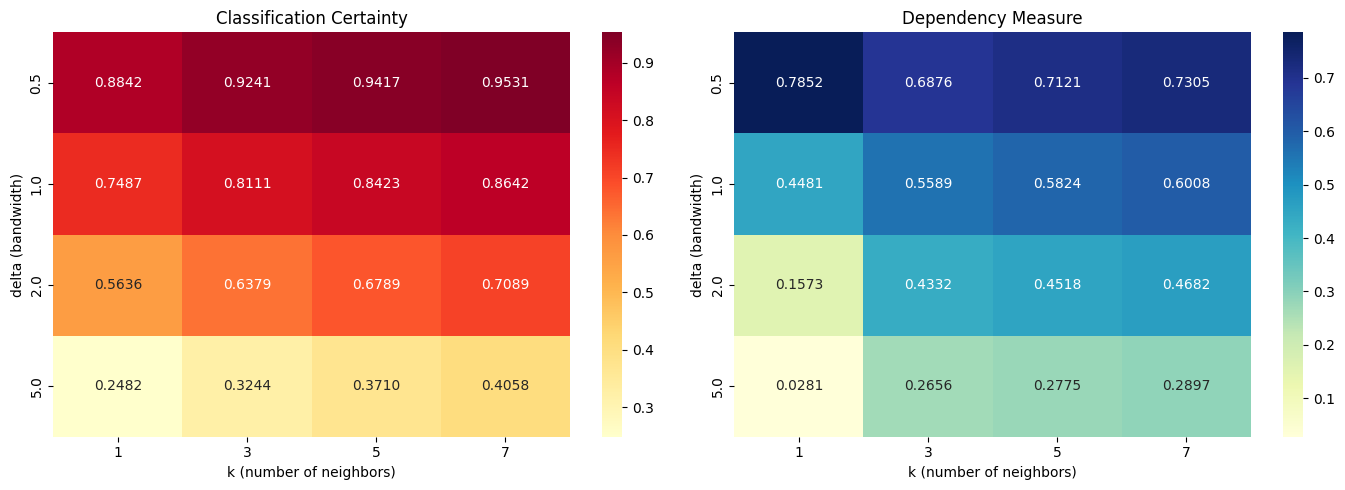

In [7]:
# Create heatmaps for the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Prepare data for heatmaps
cert_matrix = np.zeros((len(delta_values), len(k_values)))
dep_matrix = np.zeros((len(delta_values), len(k_values)))

for i, delta in enumerate(delta_values):
    for j, k in enumerate(k_values):
        cert_matrix[i, j] = certainty_results[(delta, k)]
        dep_matrix[i, j] = dependency_results[(delta, k)]

# Certainty heatmap
sns.heatmap(cert_matrix, annot=True, fmt='.4f', cmap='YlOrRd', 
            xticklabels=k_values, yticklabels=delta_values, ax=ax1)
ax1.set_xlabel('k (number of neighbors)')
ax1.set_ylabel('delta (bandwidth)')
ax1.set_title('Classification Certainty')

# Dependency heatmap
sns.heatmap(dep_matrix, annot=True, fmt='.4f', cmap='YlGnBu', 
            xticklabels=k_values, yticklabels=delta_values, ax=ax2)
ax2.set_xlabel('k (number of neighbors)')
ax2.set_ylabel('delta (bandwidth)')
ax2.set_title('Dependency Measure')

plt.tight_layout()
plt.show()

## Feature Selection Example

Test how different feature subsets perform

In [8]:
# Evaluate individual features and feature combinations
feature_names = iris.feature_names
delta = 1.0
k = 3

print("\nEvaluating individual features:")
print("="*70)

individual_scores = []

for i, feature_name in enumerate(feature_names):
    # Create dataset with only this feature
    single_feature_data = np.column_stack([X_scaled[:, i], y])
    
    cert = certainty_theta_gs(single_feature_data, delta, k)
    dep = dependency_s_gs(single_feature_data, delta, k)
    
    individual_scores.append((feature_name, cert, dep))
    print(f"{feature_name:20s}: Certainty={cert:.4f}, Dependency={dep:.4f}")

# Sort by certainty
individual_scores.sort(key=lambda x: x[1], reverse=True)
print("\nFeature ranking by certainty:")
for i, (name, cert, dep) in enumerate(individual_scores, 1):
    print(f"{i}. {name}: {cert:.4f}")


Evaluating individual features:
sepal length (cm)   : Certainty=-1.0533, Dependency=0.0314
sepal width (cm)    : Certainty=-1.4105, Dependency=0.0171
petal length (cm)   : Certainty=0.0912, Dependency=0.2887
petal width (cm)    : Certainty=0.1195, Dependency=0.2760

Feature ranking by certainty:
1. petal width (cm): 0.1195
2. petal length (cm): 0.0912
3. sepal length (cm): -1.0533
4. sepal width (cm): -1.4105


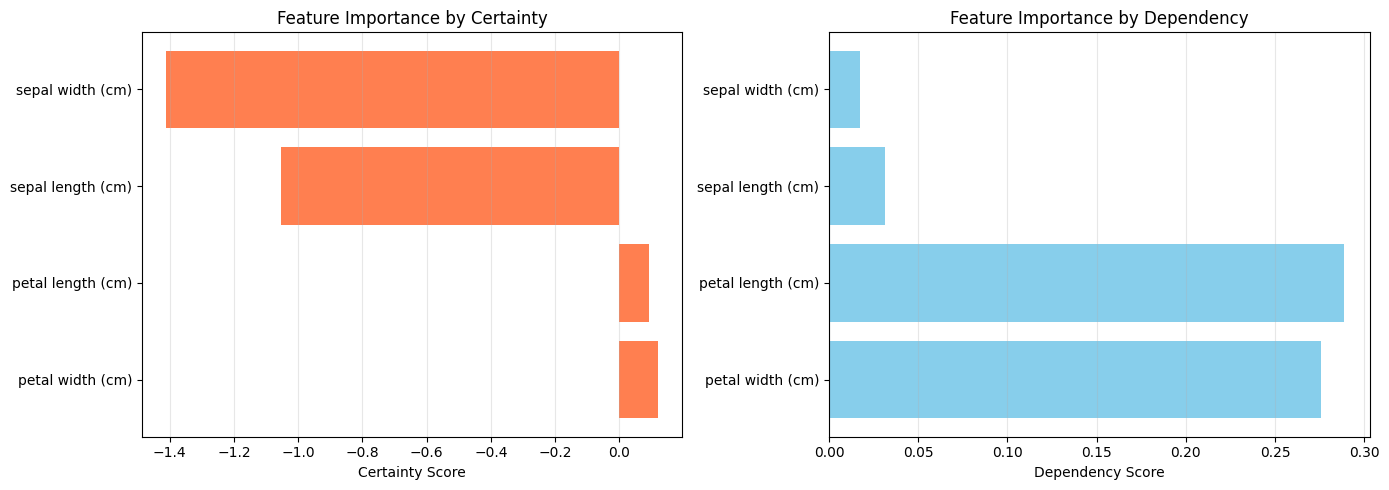

In [9]:
# Visualize feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

features = [x[0] for x in individual_scores]
certainties = [x[1] for x in individual_scores]
dependencies = [x[2] for x in individual_scores]

ax1.barh(features, certainties, color='coral')
ax1.set_xlabel('Certainty Score')
ax1.set_title('Feature Importance by Certainty')
ax1.grid(axis='x', alpha=0.3)

ax2.barh(features, dependencies, color='skyblue')
ax2.set_xlabel('Dependency Score')
ax2.set_title('Feature Importance by Dependency')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Test with Wine Dataset

In [10]:
# Load Wine dataset for additional testing
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

# Standardize
X_wine_scaled = scaler.fit_transform(X_wine)
wine_data_array = np.column_stack([X_wine_scaled, y_wine])

print("Wine Dataset:")
print(f"Shape: {wine_data_array.shape}")
print(f"Classes: {np.unique(y_wine)}")

# Compute measures
delta = 1.0
k = 5

cert_wine = certainty_theta_gs(wine_data_array, delta, k)
dep_wine = dependency_s_gs(wine_data_array, delta, k)

print(f"\nWith delta={delta}, k={k}:")
print(f"Certainty: {cert_wine:.6f}")
print(f"Dependency: {dep_wine:.6f}")

Wine Dataset:
Shape: (178, 14)
Classes: [0 1 2]

With delta=1.0, k=5:
Certainty: 0.999997
Dependency: 0.982160


## Summary

**Key Insights:**
- **Higher certainty values** indicate better class separability
- **Higher dependency values** indicate features that better distinguish between classes
- The **delta parameter** controls the fuzziness (larger = more fuzzy boundaries)
- The **k parameter** determines how many neighbors to consider
- These measures can be used for **feature selection** by comparing individual features or feature subsets